In [1]:
import os
import gc
import random
import itertools
import math
from keras.utils import plot_model, model_to_dot

from sys import getsizeof

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import Xception

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import psutil

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
old_images_path = 'Train'
old_train_path = 'train.csv'
old_test_img_path = 'Test'
old_test_path = 'test.csv'

new_image_path = "new_train"
new_train_path = "new_train.csv"
new_test_img_path = 'new_test'
new_test_path = "new_test.csv"

In [4]:
class Preprocessing:
    """
    Class for preprocessing image and CSV data for house price prediction.
    """
    def __init__(self, old_images_path, old_csv_path, old_test_img_path, old_test_path, new_test_img_path, new_test_path,  new_image_path, new_csv_path):
        """
        Initializes the Preprocessing object.

        Args:
            old_images_path: Path to the directory containing original images.
            old_csv_path: Path to the original CSV data file.
            new_image_path: Path to the directory where preprocessed images will be saved.
            new_csv_path: Path to the new CSV data file with augmented data.
        """
        
        self.old_images_path = old_images_path
        self.df = pd.read_csv(old_csv_path)
        self.old_test_img_path = old_test_img_path
        self.test_df = pd.read_csv(old_test_path)
        
        self.new_test_img_path = new_test_img_path
        self.new_test_path = new_test_path
        self.new_image_path = new_image_path
        self.new_csv_path = new_csv_path
        
        self.images = [f'{old_images_path}/{image_path}' for image_path in os.listdir(old_images_path)]
        self.test_images =  [f'{old_test_img_path}/{image_path}' for image_path in os.listdir(old_test_img_path)]
        self.image_nr = 0
        
    def crop_images(self, image):
        """
        Crops an image into four quadrants.

        Args:
            image: The image to be cropped.

        Returns:
            A tuple containing the four cropped quadrants (top-left, top-right, bottom-left, bottom-right).
        """
        image_half = int(image.shape[0]/2)
        topleft_image = image[0:image_half, 0:image_half]
        topright_image = image[0:image_half, image_half-1:-1]
        bottomleft_image = image[image_half-1:-1, 0:image_half]
        bottomright_image = image[image_half-1:-1, image_half-1:-1]
        return (topleft_image, topright_image, bottomleft_image, bottomright_image)
        
    def create_permutations(self, image):
        """
        Creates permutations of image quadrants and saves them as new images.

        Args:
            image: The image to be permuted.
        """
        topleft, topright, bottomleft, bottomright = self.crop_images(image)
        perms = list(itertools.permutations([topleft, topright, bottomleft, bottomright]))
        for permutation in perms:
            top_image = np.concatenate((permutation[0], permutation[1]), axis=1)
            bottom_image = np.concatenate((permutation[2], permutation[3]), axis=1)
            image = np.concatenate((top_image, bottom_image), axis=0)
            image = cv.resize(image, (512, 512))
            cv.imwrite(f'{self.new_image_path}/{self.image_nr}.jpg', image)
            self.image_nr += 1
            
    def get_new_images(self):
        """
        Generates and saves preprocessed images with permutations and flipping.
        """
        try:
            os.mkdir(self.new_image_path)
        except FileExistsError:
            pass
        for image_path in self.images:
            image = cv.imread(image_path)
            self.create_permutations(image)

        for image_path in self.images:
            image = cv.imread(image_path)
            image = cv.flip(image, 1)
            self.create_permutations(image)

    def get_new_train_and_test_csv(self):
        """
        Creates a new CSV file with augmented data corresponding to preprocessed images.
        """
        self.scaler = StandardScaler()
        
        X = self.df.drop(['House ID', 'Price'], axis=1)
        scaled_X = self.scaler.fit_transform(X)
        
        self.new_df = pd.DataFrame({key: value for key, value in zip(self.df.columns.difference(['House ID', 'Price']), scaled_X.T)})
        self.new_df = pd.concat([self.new_df, self.df[['House ID', 'Price']]], axis=1)
        
        new_test_df = self.test_df.drop(['House ID'], axis=1)
        new_test_df = self.scaler.transform(new_test_df)
        
        new_test_df = pd.DataFrame({key: value for key, value in zip(self.test_df.columns.difference(['House ID']), new_test_df.T)})
        self.test_df = pd.concat([new_test_df, self.test_df['House ID']], axis=1)
        
        df_duplicates = self.new_df.reindex(self.new_df.index.repeat(24)).reset_index(drop=True)

        df_duplicates = pd.concat([df_duplicates, df_duplicates])
        df_duplicates['House ID'] = range(0, len(df_duplicates))
        
        df_duplicates = df_duplicates.reset_index(drop=True)
        df_duplicates.to_csv(self.new_csv_path, index=False)
        self.test_df.to_csv(self.new_test_path, index=False)
        
    def get_new_test_images(self):
        """
        Resizes test images to 512x512
        """
        try:
            os.mkdir(self.new_test_img_path)
        except FileExistsError:
            pass
        for image_path in self.test_images:
            path = image_path.split('/')[1]
            image = cv.imread(image_path)
            image = cv.resize(image, (512, 512))
            cv.imwrite(f'{self.new_test_img_path}/{path}', image)
            
    def get_new_test_csv(self):
        """
        Scales the test csv and writes it to a new file
        """
        self.test_df = self.scaler.transform(self.test_df)
        self.test_df.to_csv(self.new_test_path)
    
    
    def shuffle_images(self):
        """
        Shuffles the order of preprocessed images and updates the CSV file accordingly.
        """
        numbers = list(range(len(os.listdir(self.new_image_path))))
        random.shuffle(numbers)
        
        df = pd.read_csv(self.new_csv_path)
        df['House ID'] = numbers
        df = df.sort_values('House ID')
        df.to_csv(self.new_csv_path, index=False)
        
        for image_name, new_image_name in zip(list(range(len(os.listdir(self.new_image_path)))), numbers):
            try:
                os.rename(f'{self.new_image_path}/{image_name}.jpg', f'{self.new_image_path}/a{new_image_name}.jpg')
            except FileNotFoundError:
                print('FileNotFoundError, perhaps the images are already shuffled')


In [5]:
# pp = Preprocessing(old_images_path, old_train_path, old_test_img_path, old_test_path, new_test_img_path, new_test_path, new_image_path, new_train_path)
# pp.get_new_test_images()
# pp.get_new_images()
# pp.get_new_train_and_test_csv()
# pp.shuffle_images()

In [6]:
class Modelling:
    """
    Class for creating and training machine learning models for house price prediction.
    """
    def __init__(self, train_path, image_path, test_path, image_test_path):
        """
        Initializes the Modelling object.

        Args:
            train_path: Path to the CSV file containing training data.
            image_path: Path to the directory containing preprocessed images.
            test_path: Path to the CSV file containing test data.
        """
        
        self.image_path = image_path
        self.image_amount = len(os.listdir(image_path))
        
        self.image_test_path = image_test_path
        self.image_test_amount = len(os.listdir(image_test_path))
        
        self.train_data = pd.read_csv(train_path)
        self.test_data_df = pd.read_csv(test_path) 
        self.test_data = self.test_data_df.to_numpy()
        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = None, None, None, None, None, None

        self.checkpoint_path = None
        self.checkpoint = None

        self.models = {'NN': 
                           {'function': self.create_NN, 
                            'model': None,
                            'train_data': None,
                            'test_data': None,
                            'history': pd.DataFrame({'loss': [math.inf], 'val_loss': [math.inf]})},  
                       'CNN': 
                           {'function': self.create_CNN, 
                            'model': None,
                            'train_data': None,
                            'test_data': None,
                            'history': pd.DataFrame({'loss': [math.inf], 'val_loss': [math.inf]})}, 
                       'Transfer': 
                           {'function': self.create_Transfer, 
                            'model': None,
                            'train_data': None,
                            'test_data': None,
                            'history': pd.DataFrame({'loss': [math.inf], 'val_loss': [math.inf]})}, 
                       'MultiModal': 
                           {'function': self.create_MultiModal, 
                            'model': None,
                            'train_data': None,
                            'test_data': None,
                            'history': pd.DataFrame({'loss': [math.inf], 'val_loss': [math.inf]})}}

        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    
    def prepare_data(self, start, end):
        """
        Prepares training and validation data for model training.

        Args:
            start: Starting index for the image range.
            end: Ending index for the image range.
        """
        amount_of_images = end - start
        
        X = self.train_data.drop(['Price'], axis=1)
        X = X.to_numpy()
        y = self.train_data['Price']
        y = y.to_numpy()
        

        images = np.empty((amount_of_images, 512, 512, 3), dtype=np.uint8)
        for i, image in enumerate(os.listdir(self.image_path)[start:end]):
            image = cv.imread(f'{self.image_path}/{image}')
            images[i, ...] = image
            
        test_images = np.empty((self.image_test_amount, 512, 512, 3), dtype=np.uint8)
        for i, image in enumerate(os.listdir(self.image_test_path)):
            image = cv.imread(f'{self.image_test_path}/{image}')
            test_images[i, ...] = image

        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = \
        train_test_split(X[start:end], images, y[start:end], test_size=0.2, random_state=42)

        self.models['NN']['train_data'] = (self.X_train_csv, self.X_val_csv)
        self.models['CNN']['train_data'] = (self.X_train_img, self.X_val_img)
        self.models['Transfer']['train_data'] = (self.X_train_img, self.X_val_img)
        self.models['MultiModal']['train_data'] = ([self.X_train_img,  self.X_train_csv], [self.X_val_img, self.X_val_csv])
        
        self.models['NN']['test_data'] = self.test_data
        self.models['CNN']['test_data'] = test_images
        self.models['Transfer']['test_data'] = test_images
        self.models['MultiModal']['test_data'] = [test_images, self.test_data]
        
    def create_NN(self):
        """
        Creates a neural network model for house price prediction.
        """
        self.models['NN']['model'] = keras.Sequential()

        self.models['NN']['model'].add(layers.Input(shape=(6)))
        self.models['NN']['model'].add(layers.Dense(256, activation='relu', name='NN_dense_1'))
        self.models['NN']['model'].add(layers.Dropout(0.5, name='NN_dropout_1'))
        self.models['NN']['model'].add(layers.Dense(128, activation='relu', name='NN_dense_2'))
        self.models['NN']['model'].add(layers.Dropout(0.3, name='NN_dropout_2'))
        self.models['NN']['model'].add(layers.Dense(64, activation='relu', name='NN_dense_3'))
        self.models['NN']['model'].add(layers.Dense(1, name='NN_dense_output'))
        
        self.models['NN']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')

    def create_CNN(self):
        """
        Creates a convolutional neural network model for house price prediction.
        """
        self.models['CNN']['model'] = keras.Sequential()
        
        self.models['CNN']['model'].add(layers.Input(shape=(512, 512, 3), name='CNN_input_img'))
        self.models['CNN']['model'].add(layers.experimental.preprocessing.Rescaling(1./255, name='CNN_rescaling'))
        self.models['CNN']['model'].add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='CNN_conv2d_1'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_1'))
        self.models['CNN']['model'].add(layers.Conv2D(32, 3, padding='same', activation='relu', name='CNN_conv2d_2'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_2'))
        self.models['CNN']['model'].add(layers.Conv2D(64, 3, padding='same', activation='relu', name='CNN_conv2d_3'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_3'))
        self.models['CNN']['model'].add(layers.Flatten(name='CNN_flatten_img'))
        self.models['CNN']['model'].add(layers.Dense(128, activation='relu', name='CNN_dense_combined'))
        self.models['CNN']['model'].add(layers.Dropout(0.3, name='CNN_dropout_1'))
        self.models['CNN']['model'].add(layers.Dense(1, name='CNN_dense_output'))

        self.models['CNN']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
        
    def create_Transfer(self):
        """
        Creates a transfer learning model using Xception for house price prediction.
        """
        self.models['Transfer']['model'] = keras.Sequential()
        
        pretrained_model = Xception(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(512, 512, 3))
        pretrained_model.trainable = False
        
        self.models['Transfer']['model'].add(pretrained_model)
        self.models['Transfer']['model'].add(layers.Input(shape=(512, 512, 3), name='Transfer_input_img'))
        self.models['Transfer']['model'].add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='Transfer_conv2d_1'))
        self.models['Transfer']['model'].add(layers.MaxPooling2D(pool_size=(2, 2), name='Transfer__max_pooling2d_1'))
        self.models['Transfer']['model'].add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='Transfer_conv2d_2'))
        self.models['Transfer']['model'].add(layers.MaxPooling2D(pool_size=(2, 2), name='Transfer__max_pooling2d_2'))
        self.models['Transfer']['model'].add(layers.GlobalAveragePooling2D(name='Transfer_GBP2D'))
        self.models['Transfer']['model'].add(layers.Dropout(0.2, name='Transfer_dropout_1'))
        self.models['Transfer']['model'].add(layers.Dense(64, activation='relu', name='Transfer_dense_1'))
        self.models['Transfer']['model'].add(layers.Dense(1, name='Transfer_output'))
        
        self.models['Transfer']['model'].compile(self.optimizer, loss='mean_absolute_percentage_error')
        
    def create_MultiModal(self):
        """
        Creates a multi-modal model combining image and CSV data for house price prediction.
        """
        img_input = layers.Input(shape=(512, 512, 3), name='MM_input_img')
        x_img = layers.experimental.preprocessing.Rescaling(1./255, name='MM_rescaling')(img_input)
        x_img = layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='MM_conv2d_1')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_1')(x_img)
        x_img = layers.Conv2D(32, 3, padding='same', activation='relu', name='MM_conv2d_2')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_2')(x_img)
        x_img = layers.Conv2D(64, 3, padding='same', activation='relu', name='MM_conv2d_3')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_3')(x_img)
        x_img = layers.Flatten(name='MM_flatten_img')(x_img)
        
        csv_input = layers.Input(shape=(6), name='MM_input_csv')
        x_csv = layers.Flatten(name='MM_flatten_csv')(csv_input)
        x_csv = layers.Dense(16, activation='relu', name='MM_dense_1')(x_csv)
        x_csv = layers.Dense(32, activation='relu', name='MM_dense_2')(x_csv)
        x_csv = layers.Dense(64, activation='relu', name='MM_dense_3')(x_csv)
        
        x = layers.concatenate([x_img, x_csv], name='MM_concatenate')
        x = layers.Dense(128, activation='relu', name='MM_dense_combined')(x)
        output = layers.Dense(1, name='MM_dense_output')(x)
        
        # make model with 2 inputs and 1 output
        self.models['MultiModal']['model'] = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

        self.models['MultiModal']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
        
    def train_models(self, models, batch_size=1000):   
        """
        Trains the specified models in batches.

        Args:
            models: A list of model names to train.
            batch_size: The number of images to process in each batch.
        """
        for model in models:
            try:
                self.models[model]['function']()
                for i in range(0, self.image_amount, batch_size):
                    start = i
                    end = min(i + batch_size, self.image_amount)
                    print(f'Training {model} on images {start} to {end}...')
                    tf.keras.backend.clear_session()
                    gc.collect()
                    self.prepare_data(start, end)
                    
                    self.checkpoint_path = f"checkpoints/{model}_checkpoint.h5"
                    self.checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', verbose=1, \
                                                      save_best_only=True, mode='min', \
                                                      initial_value_threshold=self.models[model]['history']['val_loss'].iloc[-1])
                    self.models[model]['model'].fit(self.models[model]['train_data'][0], self.y_train, epochs=50, batch_size=16, \
                                                    validation_data=(self.models[model]['train_data'][1], self.y_val), \
                                                    callbacks=[self.early_stopping, self.checkpoint], verbose=0)
                    history = pd.DataFrame(self.models[model]['model'].history.history)
                    self.models[model]['history'] = pd.concat([self.models[model]['history'], history], ignore_index=True)
                    self.models[model]['history']['loss'] = self.history_processing(self.models[model]['history']['loss'])
                    self.models[model]['history']['val_loss'] = self.history_processing(self.models[model]['history']['val_loss'])
            except KeyError:
                print('This model does not exist!')
                
    def history_processing(self, history):
        """
        Processes model training history to retain only the best (lowest) loss values.

        Args:
            history: A list of loss values from model training.

        Returns:
            A list of processed loss values.
        """
        new_history = [history[0]]
        for num in history[1:]: 
            new_history.append(min(num, new_history[-1])) 
        return new_history

    
    def load_models(self, models):
        """
        Loads the specified models by calling their associated functions.

        Args:
            models: A list of model names or objects. If a model is None, it is skipped.
        """
        try:
            for model in models:
                if model is not None:
                    self.models[model]['function']()
                self.models[model]['model'].load_weights(f"checkpoints/{model}_checkpoint.h5")
        except KeyError:
            print("KeyError in models parameter, please make sure all models exist and are spelled correctly")
    
    def plot_models(self, models):
        """
        Plots the architecture of the specified models.

        Args:
            models: A list of model names to plot.
        """
        self.load_models(models)
        
        fig, ax = plt.subplots(len(models), 1, figsize=(10, 50), dpi=200)
        
        for index, model in enumerate(models):
            model_image_path = f"model_architectures/{model}.png"
            plot_model(self.models[model]['model'], 
                       to_file=model_image_path,
                       show_shapes=True,
                       show_dtype=False,
                       show_layer_names=False)
            
            ax[index].set_xticks([])
            ax[index].set_yticks([])
            ax[index].set_title(f'{model}')
            ax[index].imshow(plt.imread(model_image_path))
            
    def predict(self, models):
        try:
            os.mkdir('predictions')
        except FileExistsError:
            pass
        
        self.load_models(models)
        for model in models:
            predictions = self.models[model]['model'].predict(self.models[model]['test_data'], batch_size=1)
            df = pd.DataFrame({'House ID': self.test_data_df['House ID'], 'Price': predictions.T[0]})
            df.to_csv(f'predictions/{model}_predictions.csv', index=False)
            tf.keras.backend.clear_session()
            gc.collect()
        
        
        
    def evaluate_models(self):
        """
        Plots the training and validation loss curves for all trained models.
        """
        fig, ax = plt.subplots(1, 2)
        for model in self.models.keys():
            plt.tight_layout()
            ax[0].plot(self.models[model]['history']['loss'][1:], label=f'{model} Train Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel('Mean Absolute Percentage Error (mape)')
            ax[0].legend()
            
            ax[1].plot(self.models[model]['history']['val_loss'][1:], label=f'{model} Val Loss')
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Mean Absolute Percentage Error (mape)')
            ax[1].legend()
            

In [7]:
modelling = Modelling(new_train_path, new_image_path, new_test_path, new_test_img_path)

In [8]:
modelling.train_models(['NN', 'CNN', 'Transfer', 'MultiModal'], batch_size=1000)

Training NN on images 0 to 1000...

Epoch 1: val_loss improved from inf to 94.47991, saving model to checkpoints\NN_checkpoint.h5

Epoch 2: val_loss improved from 94.47991 to 78.57553, saving model to checkpoints\NN_checkpoint.h5

Epoch 3: val_loss did not improve from 78.57553

Epoch 4: val_loss did not improve from 78.57553

Epoch 5: val_loss did not improve from 78.57553
Training NN on images 1000 to 2000...

Epoch 1: val_loss improved from 78.57553 to 69.06596, saving model to checkpoints\NN_checkpoint.h5

Epoch 2: val_loss did not improve from 69.06596

Epoch 3: val_loss improved from 69.06596 to 68.89076, saving model to checkpoints\NN_checkpoint.h5

Epoch 4: val_loss did not improve from 68.89076

Epoch 5: val_loss did not improve from 68.89076

Epoch 6: val_loss did not improve from 68.89076
Training NN on images 2000 to 3000...

Epoch 1: val_loss did not improve from 68.89076

Epoch 2: val_loss did not improve from 68.89076

Epoch 3: val_loss did not improve from 68.89076

Epo

In [9]:
modelling.predict(['NN', 'CNN', 'Transfer', 'MultiModal'])

35/35 [==============================] - 0s 2ms/step


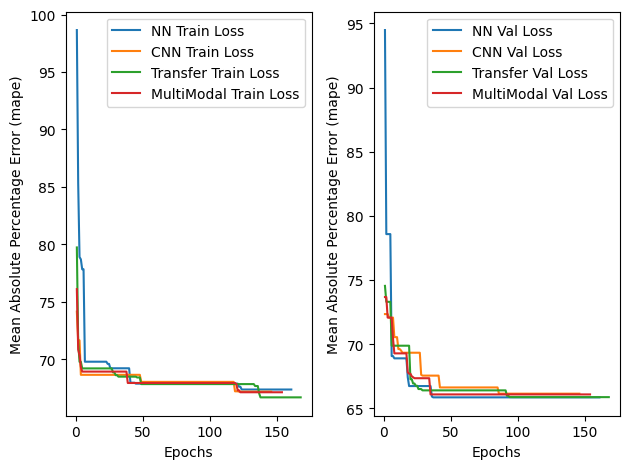

In [10]:
modelling.evaluate_models()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


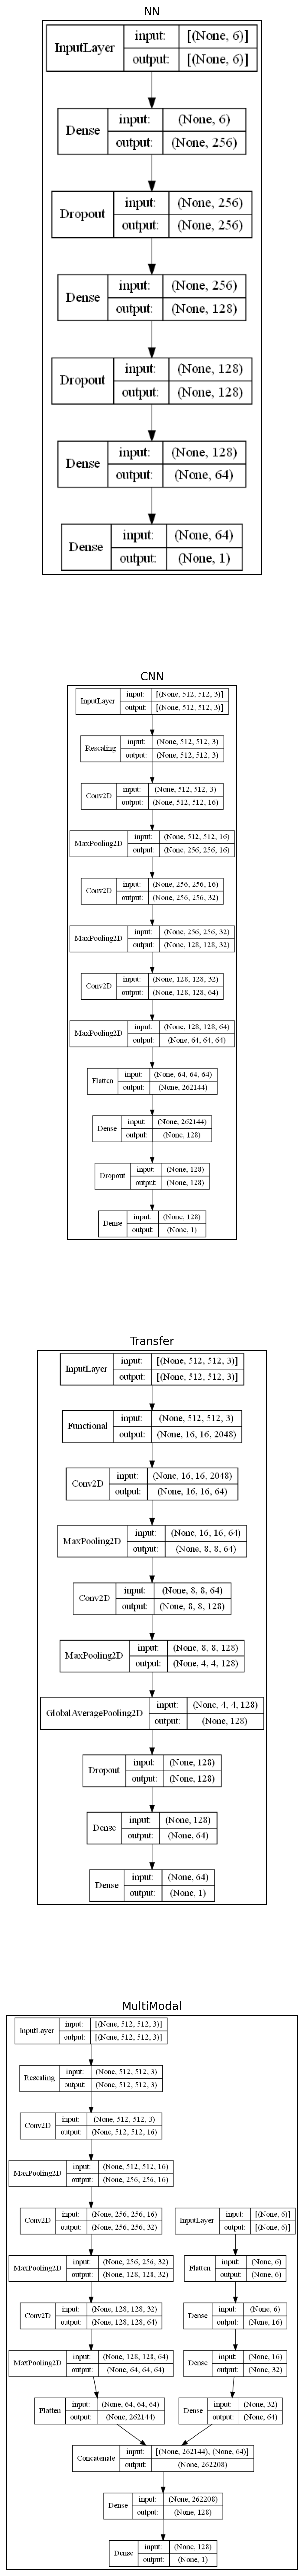

In [11]:
modelling.plot_models(['NN', 'CNN', 'Transfer', 'MultiModal'])